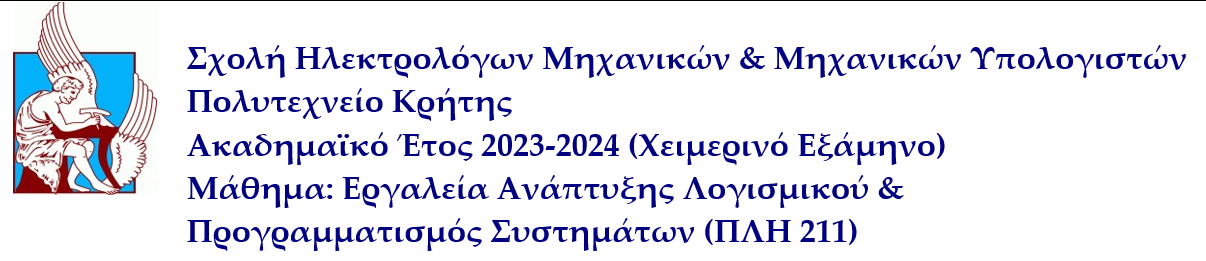

### Στοιχεία Φοιτητών Ομάδας
---
#### Φοιτητής 1
##### Αριθμός Μητρώου: 2020030058
##### Όνοματεπώνυμο: ΧΑΡΙΛΑΟΣ ΚΑΠΕΛΩΝΗΣ
##### Phases στα οποία εργάστηκε: όλα
---

# Εργασία 1 - Θέμα: Ανάπτυξη Λογισμικού Aggregative News Analyzer

---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰
# ΔΕΝ προχωράμε παρακάτω σε αυτό το notebook αν δεν έχουμε διαβάσει και είμαστε έτοιμοι να εφαρμόσουμε ακριβώς τις οδηγίες που διανέμονται μαζί με αυτή την εργασία στο PLH211_Project1_2023_2024_Directions.docx.
---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰

<font color='red'> Στα πλαίσια της εργασίας δεν μπορείτε να υποθέσετε ότι τα news και άρα τα αρχεία που σας δίδονται δεν αλλάζουν ποτέ. Το αρχείο με τα news θεωρείται μεταβλητό καθώς σε ένα πραγματικό σενάριο τα news ανανεώνονται σε τακτά χρονικά διαστήματα. Άρα δεν μπορείτε να προ-υπολογίσετε το Jaccard Index και όσα άλλα ζητούνται μόνο μια φορά και να τα σώσετε μια μόνο φορά σε αρχείο.</font>  

# Development Phase

## ⏩ Κώδικας Development Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που υλοποιεί τον Aggregative News Analyzer σας.

In [ ]:
import json
from openpyxl import Workbook
from openpyxl.styles import Font


NUM_OF_PARTS = 5 # min = 1, max = 5

MAX_ROWS_XLSX = 1048570

COLAB_DIR = '/content/drive/MyDrive/Colab Notebooks/'
FILE_1 = COLAB_DIR + 'datasets/rcv1-v2.topics.qrels.txt'
FILES_2 = [f'{COLAB_DIR}datasets/lyrl2004_vectors_test_pt{i}.dat.txt' for i in range(NUM_OF_PARTS)]
FILE_3 = COLAB_DIR + 'datasets/stem.termid.idf.map.txt'

INITIAL_PROMPT = """
What do you want to do?
1) Get the <k> most relevant stems for a <category>: @ <category> <k>
2) Get the <k> most relevant categories for a <stem>: # <stem> <k>
3) Save all the <stem> <category> <Jaccard Index Score> combinations: * <filename>.<filetype>
   Please note that the supported filetypes are: xlsx or json.
4) Get all the categories or stems of the document with <did> doc id (flag -c, -t): P <did> -c|-t
5) Get the num of categories or num of stems of the document with <did> doc id (flag -c, -t): C <did> -c|-t
6) Type anything else to exit.
"""



"""
	We get a dictionary with categories as keys and
	list of documents as values, like this:

	{'C11': ['2290'],
	 'C12': ['2295', '2299', '2305', '2306', '2311'],
	 'C13': ['2296', '2304'],
	 ...}

	We load num lines (if n >= 0) else all of them (if n < 0)
"""
def load_document_categories(file_path, num=-1):
	dc_dict = {}
	with open(file_path, "r", encoding="utf8") as dc:
		lines = dc.readlines()[:num] if num >= 0 else dc.readlines()
		for line in lines:
			pair = line[:-3] # throwing the 1's
			pair = pair.split(' ')

			category = pair[0]
			document = pair[1]

			if category not in dc_dict.keys():
				dc_dict[category] = []

			dc_dict[category].append(document)

	return dc_dict

"""
	We get a dictionary with terms as keys and
	list of documents as values, like this:

	{"36975": [
		"254225",
		"254237",
		"280007",
		"280011",
		...]
	...}

	We load num lines (from each file) (if n >= 0) else all of them (if n < 0)
"""
def load_document_terms(file_path, num=-1):
	dt_dict = {}
	for part in file_path:
		with open(part, "r", encoding="utf8") as dt_part:
			lines = dt_part.readlines()[:num] if num >= 0 else dt_part.readlines()
			for line in lines:
				temp = line.split(" ")
				document = temp[0]
				terms = [x.split(":")[0] for x in temp[2:]]

				for term in terms:
					if term not in dt_dict.keys():
						dt_dict[term] = []
					dt_dict[term].append(document)

	return dt_dict

"""
	Every stem in the list has term_id = list:index + 1
"""
def load_terms_mapping(file_path):
	stems_terms = []
	with open(file_path, "r", encoding="utf8") as t:
		for line in t.readlines():
			stems_terms.append(line.split(" ")[:2][0])

	return stems_terms

"""
	Returns the score as float with five decimals.
								|intersection|
	J(T, C) = ------------------------------------------------------
				|docs_per_category| + |docs_per_term| - |intersection|
"""
def jaccard_index(a, b, i):
	return "{:.5f}".format(i / (a + b - i))


def command_1(category, k, cat_dict, term_dict, stem_list):
	document_list = cat_dict[category]
	a = len(document_list)
	terms_score = []

	for term in term_dict.keys():
		docs_with_term = term_dict[term]
		b = len(docs_with_term)
		if (b > 0):
			intersection = len(set(document_list).intersection(docs_with_term))
			terms_score.append([stem_list[int(term)-1], jaccard_index(a, b, intersection)])

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

def command_2(stem, k, cat_dict, term_dict, stem_list):
	term_id = stem_list.index(stem) + 1
	document_list = term_dict[str(term_id)]

	a = len(document_list)
	terms_score = []

	for category in cat_dict.keys():
		docs_of_category = cat_dict[category]
		b = len(docs_of_category)

		intersection = len(set(document_list).intersection(docs_of_category))
		terms_score.append([category, jaccard_index(a, b, intersection)])

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

def command_3(stem, category, cat_dict, term_dict, stem_list):
	term_id = stem_list.index(stem) + 1
	document_list1 = cat_dict[category]
	document_list2 = term_dict[str(term_id)]

	a = len(document_list1)
	b = len(document_list2)

	intersection = len(set(document_list1).intersection(document_list2))

	return [stem, category, jaccard_index(a, b, intersection)]

def command_4(filename, cat_dict, term_dict, stem_list):
	elem_list = []
	for category in cat_dict.keys():
		document_list = cat_dict[category]
		a = len(document_list)
		for term in term_dict.keys():
			docs_with_term = term_dict[term]
			b = len(docs_with_term)
			intersection = len(set(document_list).intersection(docs_with_term))

			elem = {
				"Stem": stem_list[int(term)-1],
				"Category": category,
				"JI Score": jaccard_index(a, b, intersection)
				}

			elem_list.append(elem)

	type_of_file = filename.split(".")[1]
	file_dest = COLAB_DIR + filename
	if (type_of_file == 'xlsx'):
		excel = Workbook()
		excel_sheet = excel.active
		excel_sheet.append(["Stem", "Category", "JI Score"])
		for index in ['A1', 'B1', 'C1']:
			excel_sheet[index].font = Font(size=14, bold=True)
		for i, elem in enumerate(elem_list):
			if (i >= MAX_ROWS_XLSX):
				break
			excel_sheet.append(list(elem.values()))
		excel.save(file_dest)
	elif (type_of_file == 'json'):
		with open(file_dest, 'w') as json_file:
			json.dump(elem_list, json_file, indent=4)

def command_5(doc_id, identifier, cat_dict, term_dict, stem_list):
	result = []
	if (identifier == '-c'):
		for category in cat_dict.keys():
			if doc_id in cat_dict[category]:
				result.append(category)
	elif (identifier == '-t'):
		for term in term_dict.keys():
			if doc_id in term_dict[term]:
				result.append(stem_list[int(term)-1])
	else:
		raise ValueError
	return result

def command_6(doc_id, identifier, cat_dict, term_dict, stem_list):
	return len(command_5(doc_id, identifier, cat_dict, term_dict, stem_list))

def cli(command, cat_dict, term_dict, stem_list):
	command_split = command.split(" ")
	command_symbol = command_split[0]

	if (command_symbol == '@'):
		category = command_split[1]
		k = int(command_split[2])
		print(command_1(category, k, cat_dict, term_dict, stem_list))
	elif (command_symbol == '#'):
		stem = command_split[1]
		k = int(command_split[2])
		print(command_2(stem, k, cat_dict, term_dict, stem_list))
	elif (command_symbol == '$'):
		stem = command_split[1]
		category = command_split[2]
		print(command_3(stem, category, cat_dict, term_dict, stem_list))
	elif (command_symbol == '*'):
		filename = command_split[1]
		command_4(filename, cat_dict, term_dict, stem_list)
	elif (command_symbol == 'P'):
		doc_id = command_split[1]
		identifier = command_split[2]
		print(command_5(doc_id, identifier, cat_dict, term_dict, stem_list))
	elif (command_symbol == 'C'):
		doc_id = command_split[1]
		identifier = command_split[2]
		print(command_6(doc_id, identifier, cat_dict, term_dict, stem_list))
	else:
		raise ValueError

def main():
	print("Hello! Wait a minute.")
	print("Loading datasets...")

	# we load the files once in the respective collections
	cat_dict = load_document_categories(FILE_1)
	term_dict = load_document_terms(FILES_2)
	stem_list = load_terms_mapping(FILE_3)

	while True:
		try:
			cli(input(INITIAL_PROMPT), cat_dict, term_dict, stem_list)
		except ValueError:
			print("Bye bye! :)")
			return

if (__name__ == "__main__"):
	main()


## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Developement Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Development Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### *Ακολουθεί η τεκμηρίωση και ο σχολιασμός κώδικα της Development Phase:*

# **Συνοπτικά:**

Η εργασία ζητάει τον προγραμματισμό ενός περιβάλλοντος μορφής **C**ommand **L**ine **I**nterface (**CLI**) για ένα λογισμικό **συγκεντρωτικού αναλυτή αρχείου ειδήσεων** με πρωταγωνιστές τα αρχεία ειδήσεων, τις κατηγορίες που ανήκουν και τους βασικούς όρους που περιέχουν, με επίκεντρο της προσοχής το δυναμικό κατηγοριών-όρων και το τι σχέση έχουν, κάνοντας χρήση του Jaccard Index.

# **Αναλυτικά:**
Θα περιγραφούν αναλυτικά και με code snippets τα στάδια ανάπτυξης του κώδικα:
## 1. Φόρτωμα των Datasets:
Πρώτο βήμα ήταν να φορτωθούν τα datasets, τα οποία ανέβηκαν στο προσωπικό μου λογαριασμό του Google Drive και, έπειτα από το mount στο παρόν notebook, τα 7 αρχεία βρίσκονταν στον εξής φάκελο:

```python
COLAB_DIR = '/content/drive/MyDrive/Colab Notebooks/'
FILE_1 = COLAB_DIR + 'datasets/rcv1-v2.topics.qrels.txt'
FILES_2 = [f'{COLAB_DIR}datasets/lyrl2004_vectors_test_pt{i}.dat.txt' for i in range(NUM_OF_PARTS)]
FILE_3 = COLAB_DIR + 'datasets/stem.termid.idf.map.txt'
```
με:
```python
NUM_OF_PARTS = 5 # min = 1, max = 5
```
ώστε να μπορούν να φορτωθούν όσα parts θέλουμε.

Εδώ να σημειωθούν δύο μικρές λεπτομέρειες:
1. το πέμπτο και μικρότερο αρχείο των `FILES_2` μετονομάστηκε από `lyrl2004_vectors_train.dat.txt` σε `lyrl2004_vectors_test_pt4.dat.txt` για χάριν ευκολίας και ομοιομορφίας, και
2. στο `FILE_3` έσβησα τα junk data στην αρχή του αρχείου

Και όσον αφορά τον αντίστοιχο κώδικα (βλ. σχόλια κώδικα για λεπτομέρειες):
* ### Κατηγορίες - Αρχεία ειδήσεων:

  Ορίστηκε η συνάρτηση `load_document_categories(file_path, num=-1)` η οποία επιστρέφει ένα dictionary με keys τις κατηγορίες και values (για **κάθε** κατηγορία) μία λίστα με τα αρχεία ειδήσεων που ανήκουν σε αυτήν.

* ### Όροι - Αρχεία ειδήσεων:

  Ορίστηκε η συνάρτηση `load_document_terms(file_path, num=-1)` η οποία επιστρέφει ένα dictionary με keys τους όρους και values (για **κάθε** όρο) μία λίστα με τα αρχεία ειδήσεων που περιέχουν τον όρο αυτόν.

* ### Όροι - Κωδικοί όρων:

  Εδώ ήταν μία ιδιαίτερη περίπτωση mapping, όπου κάθε αγγλική λέξη αντιστοιχούσε σε έναν κωδικό με αύξοντα αριθμό ξεκινώντας από το 1. Μέσω της συνάρτησης `load_terms_mapping(file_path)` διαβάστηκαν οι λέξεις αυτές και τοποθετήθηκαν σε μία λίστα που κάθε index της λίστας αυτής ***+ 1*** (!!!) (λόγω των zero-indexed collections στην Python) αντιστοιχούσε στον κωδικό της λέξης.

## 2. Jaccard Index:

Η συνάρτηση από μόνη της ήταν απλή. Προτιμήθηκε να κρατιούνται μόνο 5 δεκαδικά ψηφία από κάθε σκορ:
```python
def jaccard_index(a, b, i):
	return "{:.5f}".format(i / (a + b - i))
```

## 3. CLI και Commands:

Αρχικά δημιουργήθηκε η `cli(command, cat_dict, term_dict, stem_list)` συνάρτηση η οποία θα καλείται στο `while True` loop της `main`. Το όρισμα `command` είναι από το `input()` του χρήστη και δίδονται από την `main` και τα τρία collections με τα δεδομένα (βλ. *4. Main function*).

Για κάθε μία από τις 6 δυνατές περιπτώσεις/ εντολές δημιουργήθηκε μία συνάρτηση `command_*(...)` που έκανε return το αποτέλεσμα πίσω στην `cli` και η οποία αποφασίζει τι θα το κάνει ανάλογα την περίπτωση (print, ignore κ.λπ.).

Αφότου γίνεται `split` το `string command`, ελέγχουμε τις περιπτώσεις του πρώτου χαρακτήρα και περνάμε τα ορίσματα στις αντίστοιχες συναρτήσεις. Οι συναρτήσεις `command_*(...)` δεν είναι τέλειες και σίγουρα θα μπορούσε να γίνει καλύτερη ανακύκλωση του κώδικα. Αλλά το σίγουρο είναι ότι 1) η επιλογή των dictionaries και, 2) των keys να είναι οι κατηγορίες και οι όροι βοηθάει πολύ, αφού έχουν `O(1)` πολυπλοκότητα και μπορούμε γρήγορα να τις διασχίζουμε, αλλά και να κάνουμε τυχαία προσπέλαση. Όλες οι συναρτήσεις περιστρέφονται γύρω από το πάρσιμο των δύο λιστών με documents (μία για κατηγορία και μία για όρο) και την τομή τους. Από εκεί και πέρα υπολογίζονται οι αντίστοιχες πληθικότητες των συνόλων.

Δε θα σταθώ σε χρόνους και μνήμη σε αυτή τη φάση, αλλά για παράδειγμα το τέταρτο command δεν τρέχει με τίποτα πάνω σε όλα τα δεδομένα. Επίσης, αναφορικά με το τέταρτο command, τα `.xlsx` αρχεία έχουν max αριθμό γραμμών ανά sheet, το οποίο κατά το γράψιμο στο αρχείο excel ελέγχεται, και αν υπερβληθεί τερματίζεται το γράψιμο γιατί αλλιώς το αρχείο δεν ανοίγει (βλ. `MAX_ROWS_XLSX = 1048570`).

*Σημειώνω ότι αντιλαμβάνομαι την έλλειψη πρόληψης και εφαρμογής τακτικών **αμυντικού προγραμματισμού**, αλλά δε θεώρησα τον εξαντλητικό έλεγχο περιπτώσεων απαραίτητο σε κάποια σημεία και τυχούσες κακοπροαίρετες διαθέσεις του χρήστη αντιμετωπίζονται με απλά `raise Error` και `try-except` clauses.*

## 4. Main function:
Όπως και ζητήθηκε, η `main` είναι ένα `while loop`, αφότου πρώτα έχουν φορτωθεί τα αρχεία. Βγαίνει ένα prompt και ο χρήστης πληκτρολογεί ό,τι θέλει. Τερματίζεται αν ο χρήστης πληκτρολογήσει κάτι που δεν είναι εντολή.

# **Επίλογος:**
Έως τώρα καταλήγω στο ότι έχουμε έναν runnable κώδικα, με `prints` από 'δω κι από εκεί είδα αναμενόμενα αποτελέσματα, και αναγνωρίζω ότι δεν είναι optimized.

# Logging Phase


## ⏩ Κώδικας Logging Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που φτιάχνει το myeditorlog.conf αρχείο με το configuration (loggers, handlers, formatters) του logger σας.

`format=%(asctime)s - %(name)s - %(levelname)s - %(message)s `

In [ ]:
%%file myeditorlog.conf
[loggers]
keys=root,newsLogger

[handlers]
keys=newsHandler

[formatters]
keys=newsFormatter

[logger_root]
level=INFO
handlers=newsHandler

[logger_newsLogger]
level=INFO
handlers=newsHandler
qualname=newsLogger
propagate=0

[handler_newsHandler]
class=FileHandler
level=DEBUG
formatter=newsFormatter
args=('/content/drive/MyDrive/Colab Notebooks/logme.txt', 'a')

[formatter_newsFormatter]
format=%(asctime)s - %(name)s - %(levelname)s - %(message)s


Γράψτε στο παρακάτω code cell τον κώδικα του Aggregative News Analyzer όπως ήταν στο Developement phase ΑΛΛΑ εδώ θα έχει και εισαγωγή των κατάλληλων εντολών που δημιουργούν τα LogRecords ώστε αυτά να γράφονται σε ένα αρχείο logme.txt .

In [ ]:
import json
from openpyxl import Workbook
from openpyxl.styles import Font
import logging
import logging.config
import os

NUM_OF_PARTS = 5 # min = 1, max = 5

MAX_ROWS_XLSX = 1048570

COLAB_DIR = '/content/drive/MyDrive/Colab Notebooks/'
FILE_1 = COLAB_DIR + 'datasets/rcv1-v2.topics.qrels.txt'
FILES_2 = [f'{COLAB_DIR}datasets/lyrl2004_vectors_test_pt{i}.dat.txt' for i in range(NUM_OF_PARTS)]
FILE_3 = COLAB_DIR + 'datasets/stem.termid.idf.map.txt'

INITIAL_PROMPT = """
What do you want to do?
1) Get the <k> most relevant stems for a <category>: @ <category> <k>
2) Get the <k> most relevant categories for a <stem>: # <stem> <k>
3) Save all the <stem> <category> <Jaccard Index Score> combinations: * <filename>.<filetype>
   Please note that the supported filetypes are: xlsx or json.
4) Get all the categories or stems of the document with <did> doc id (flag -c, -t): P <did> -c|-t
5) Get the num of categories or num of stems of the document with <did> doc id (flag -c, -t): C <did> -c|-t
6) Type anything else to exit.
"""



"""
	We get a dictionary with categories as keys and
	list of documents as values, like this:

	{'C11': ['2290'],
	 'C12': ['2295', '2299', '2305', '2306', '2311'],
	 'C13': ['2296', '2304'],
	 ...}

	We load num lines (if n >= 0) else all of them (if n < 0)
"""
def load_document_categories(file_path, num=-1):
	dc_dict = {}
	with open(file_path, "r", encoding="utf8") as dc:
		lines = dc.readlines()[:num] if num >= 0 else dc.readlines()
		logger.info(f'Reading {len(lines)} lines from file {file_path}.')
		for line in lines:
			pair = line[:-3] # throwing the 1's
			pair = pair.split(' ')

			category = pair[0]
			document = pair[1]

			if category not in dc_dict.keys():
				dc_dict[category] = []

			dc_dict[category].append(document)
	logger.info(f'Completed reading file.')
	return dc_dict

"""
	We get a dictionary with terms as keys and
	list of documents as values, like this:

	{"36975": [
		"254225",
		"254237",
		"280007",
		"280011",
		...]
	...}

	We load num lines (from each file) (if n >= 0) else all of them (if n < 0)
"""
def load_document_terms(file_path, num=-1):
	dt_dict = {}
	for part in file_path:
		with open(part, "r", encoding="utf8") as dt_part:
			lines = dt_part.readlines()[:num] if num >= 0 else dt_part.readlines()
			logger.info(f'Reading {len(lines)} lines from file {part}.')
			for line in lines:
				temp = line.split(" ")
				document = temp[0]
				terms = [x.split(":")[0] for x in temp[2:]]

				for term in terms:
					if term not in dt_dict.keys():
						dt_dict[term] = []
					dt_dict[term].append(document)
		logger.info(f'Completed reading lines of {part}.')
	logger.info(f'Completed reading files.')
	return dt_dict

"""
	Every stem in the list has term_id = list:index + 1
"""
def load_terms_mapping(file_path):
	stems_terms = []
	with open(file_path, "r", encoding="utf8") as t:
		logger.info(f'Reading mappping from file {file_path}.')
		for line in t.readlines():
			stems_terms.append(line.split(" ")[:2][0])
	logger.info(f'Completed reading.')
	return stems_terms

"""
	Returns the score as float with five decimals.
								|intersection|
	J(T, C) = ------------------------------------------------------
				|docs_per_category| + |docs_per_term| - |intersection|
"""
def jaccard_index(a, b, i):
	return "{:.5f}".format(i / (a + b - i))


def command_1(category, k, cat_dict, term_dict, stem_list):
	document_list = cat_dict[category]
	a = len(document_list)
	terms_score = []

	for term in term_dict.keys():
		docs_with_term = term_dict[term]
		b = len(docs_with_term)
		if (b > 0):
			intersection = len(set(document_list).intersection(docs_with_term))
			terms_score.append([stem_list[int(term)-1], jaccard_index(a, b, intersection)])

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

def command_2(stem, k, cat_dict, term_dict, stem_list):
	term_id = stem_list.index(stem) + 1
	document_list = term_dict[str(term_id)]

	a = len(document_list)
	terms_score = []

	for category in cat_dict.keys():
		docs_of_category = cat_dict[category]
		b = len(docs_of_category)

		intersection = len(set(document_list).intersection(docs_of_category))
		terms_score.append([category, jaccard_index(a, b, intersection)])

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

def command_3(stem, category, cat_dict, term_dict, stem_list):
	term_id = stem_list.index(stem) + 1
	document_list1 = cat_dict[category]
	document_list2 = term_dict[str(term_id)]

	a = len(document_list1)
	b = len(document_list2)

	intersection = len(set(document_list1).intersection(document_list2))

	return [stem, category, jaccard_index(a, b, intersection)]

def command_4(filename, cat_dict, term_dict, stem_list):
	elem_list = []
	for category in cat_dict.keys():
		document_list = cat_dict[category]
		a = len(document_list)
		for term in term_dict.keys():
			docs_with_term = term_dict[term]
			b = len(docs_with_term)
			intersection = len(set(document_list).intersection(docs_with_term))

			elem = {
				"Stem": stem_list[int(term)-1],
				"Category": category,
				"JI Score": jaccard_index(a, b, intersection)
				}

			elem_list.append(elem)

	type_of_file = filename.split(".")[1]
	file_dest = COLAB_DIR + filename
	if (type_of_file == 'xlsx'):
		excel = Workbook()
		excel_sheet = excel.active
		excel_sheet.append(["Stem", "Category", "JI Score"])
		for index in ['A1', 'B1', 'C1']:
			excel_sheet[index].font = Font(size=14, bold=True)
		for i, elem in enumerate(elem_list):
			if (i >= MAX_ROWS_XLSX):
				logger.warning(f'Max rows for xlsx file reached! Stopping writing data.')
				break
			excel_sheet.append(list(elem.values()))
		excel.save(file_dest)
		logger.info(f'Excel file {filename} created successfully with {len(elem_list) + 1} rows.')
	elif (type_of_file == 'json'):
		with open(file_dest, 'w') as json_file:
			json.dump(elem_list, json_file, indent=4)
		logger.info(f'JSON file {filename} created successfully with {len(elem_list)} records.')

def command_5(doc_id, identifier, cat_dict, term_dict, stem_list):
	result = []
	if (identifier == '-c'):
		for category in cat_dict.keys():
			if doc_id in cat_dict[category]:
				result.append(category)
	elif (identifier == '-t'):
		for term in term_dict.keys():
			if doc_id in term_dict[term]:
				result.append(stem_list[int(term)-1])
	return result

def command_6(doc_id, identifier, cat_dict, term_dict, stem_list):
	return len(command_5(doc_id, identifier, cat_dict, term_dict, stem_list))

def cli(command, cat_dict, term_dict, stem_list):
	command_split = command.split(" ")
	command_symbol = command_split[0]

	logger.info(f"Command with symbol '{command_symbol}' is being executed.")

	if (command_symbol == '@'):
		category = command_split[1]
		k = int(command_split[2])
		print(command_1(category, k, cat_dict, term_dict, stem_list))
	elif (command_symbol == '#'):
		stem = command_split[1]
		k = int(command_split[2])
		print(command_2(stem, k, cat_dict, term_dict, stem_list))
	elif (command_symbol == '$'):
		stem = command_split[1]
		category = command_split[2]
		print(command_3(stem, category, cat_dict, term_dict, stem_list))
	elif (command_symbol == '*'):
		filename = command_split[1]
		command_4(filename, cat_dict, term_dict, stem_list)
	elif (command_symbol == 'P'):
		doc_id = command_split[1]
		identifier = command_split[2]
		print(command_5(doc_id, identifier, cat_dict, term_dict, stem_list))
	elif (command_symbol == 'C'):
		doc_id = command_split[1]
		identifier = command_split[2]
		print(command_6(doc_id, identifier, cat_dict, term_dict, stem_list))
	else:
		raise TypeError

	logger.info(f"Command with symbol '{command_symbol}' successfully executed.")


def main():
	print("Hello! Wait a minute.")
	print("Initializing logger...")

	if (os.path.exists('/content/drive/MyDrive/Colab Notebooks/logme.txt')):
		os.remove('/content/drive/MyDrive/Colab Notebooks/logme.txt')
	logging.config.fileConfig('myeditorlog.conf', disable_existing_loggers=False)

	# Get the logger specified in the file
	global logger
	logger = logging.getLogger(__name__)

	print("Loading datasets...")
	logger.info(f"Initialize loading datasets process.")
	# we load the files once in the respective collections
	cat_dict = load_document_categories(FILE_1)
	term_dict = load_document_terms(FILES_2)
	stem_list = load_terms_mapping(FILE_3)

	while True:
		try:
			user_request = input(INITIAL_PROMPT)
			logger.info(f"User requested: {user_request}.")
			cli(user_request, cat_dict, term_dict, stem_list)
		except TypeError:
			logger.info(f"Terminating program.")
			print("Bye bye! :)")
			return

if (__name__ == "__main__"):
	main()


## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Logging Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Logging Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

### *Ακολουθεί η τεκμηρίωση και ο σχολιασμός κώδικα της Logging Phase:*

# **Για το `myeditorlog.conf` αρχείο:**

Ακολουθώντας τις οδηγίες της αντίστοιχης διάλεξης, γράφτηκε ο κώδικας που δημιουργεί το `.conf` αρχείο. Δηλαδή, δε χρησιμοποιήθηκε ο `root` logger, αλλά ένας με όνομα `newsLogger` (με base level `INFO`) που είχε ως handler τον `newsHandler`. Ο `newsHandler` με τη σειρά του ήταν κλάσης `FileHandler`, αφού γράφουμε στο αρχείο `logme.txt`, και με όρισμα `a(ppend)` για να καταγράφουμε ό,τι γίνεται σε ένα session. Εδώ σημειώνεται ότι το `level` του handler είναι `DEBUG`, αλλά δε μας απασχολεί, αφού ούτως ή άλλως το `level` του logger είναι `INFO`. Τέλος, ο handler παίρνει και τον `newsFormatter` ως formatter, ο οποίος, όπως ζητήθηκε, κάνει format με τον εξής τρόπο: `format=%(asctime)s - %(name)s - %(levelname)s - %(message)s`.

*Σημείωση: λογικά το timezone το οποίο παίρνει το Google Colab δεν είναι Ελλάδας, με αποτέλεσμα στο `logme.txt` αρχείο να βλέπουμε ενέργειες με διαφορά ώρας από Ελλάδα, αλλά διαφορετικό (ίσως ανάλογα με το που σε συνδέσει σε κάθε session), και στο διαδίκτυο δε βρήκα μία απλή λύση, άρα το κάνω acknowledge και το αγνοώ.*


# **Για τις αλλαγές στον κώδικα (σε ποια σημεία γίνεται logging):**
Αρχικά να αναφερθεί ότι έγινε import και χρήση του `os` της python για να ελέγχεται σε κάθε run του προγράμματος αν υπάρχει ήδη `logme.txt` αρχείο και να διαγράφεται (η εκφώνηση ζητάει *να logάρονται μόνο οι εντολές/ενέργειες του τελευταίου χρήστη που το έτρεξε*).
* LEVEL `INFO`: τέτοια logs έγιναν σε σημεία που γινόταν μια διαδικασία, για παράδειγμα, όταν διαβάζαμε ένα αρχείο το καταγράφαμε πριν ξεκινήσει το διάβασμα, και όταν τελείωνε, **ΑΝ** πετύχαινε, το καταγράφαμε κι αυτό. Κράτησα τα logs όσο γίνεται έξω από τις ίδιες τις συναρτήσεις `command_*` και περισσότερο στην συνάρτηση `cli` και `main`, καθώς και στα διαβάσματα αρχείων.
* LEVEL `WARNING`: συμβαίνει σε ένα σημείο μόνο, όταν φτάσουμε `MAX_ROWS_XLSX`.

# Profiling Phase

## ⏩ Κώδικας Profiling Phase

Γράψτε σε ένα ή περισσότερο code cells τον κώδικα του Aggregative News Analyzer με τις εντολές που προσθέσατε για profiling.

*Υπόδειξη: Θα σας είναι πιο εύκολο να το κάνετε αυτό συμβουλευόμενοι την ενότητα Beyond Interactive Notebooks - Profiling in IDEs της αντίστοιχης διάλεξης και το line profiler ή/και το cProfiler, memory_profiler. Αυτή τη φάση μπορείτε και συστήνεται να τη δουλέψετε σε loops με το refactoring. Δλδ μπορείτε εδώ να δοκιμάσετε εναλλακτικές υλοποιήσεις, να μετρήσετε την απόδοσή τους ώστε να επιχειρηματολογήσετε στην επόμενη φάση για το πως κάνατε refactor των κώδικά σας.*

### **Κάποιες αρχικές εντολές:**

In [ ]:
!pip install line_profiler
!pip install memory_profiler

In [ ]:
%load_ext line_profiler
%load_ext memory_profiler

### `load_document_categories`


In [ ]:
%lprun -f load_document_categories load_document_categories(FILE_1)

In [ ]:
# VERSION 1
def load_document_categories(file_path, num=-1):
	dc_dict = {}
	with open(file_path, "r", encoding="utf8") as dc:
		lines = dc.readlines()[:num] if num >= 0 else dc.readlines()
		logger.info(f'Reading {len(lines)} lines from file {file_path}.')
		for line in lines:
			pair = line[:-3] # throwing the 1's
			pair = pair.split(' ')

			category = pair[0]
			document = pair[1]

			if category not in dc_dict.keys():
				dc_dict[category] = []

			dc_dict[category].append(document)
	logger.info(f'Completed reading file.')
	return dc_dict

    Timer unit: 1e-09 s
    
    Total time: 9.19444 s
    File: <ipython-input-29-a66bc1ff4c93>
    Function: load_document_categories at line 2

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def load_document_categories(file_path, num=-1):
     3         1       1100.0   1100.0      0.0  	dc_dict = {}
     4         2   12895638.0    6e+06      0.1  	with open(file_path, "r", encoding="utf8") as dc:
     5         1  334158877.0    3e+08      3.6  		lines = dc.readlines()[:num] if num >= 0 else dc.readlines()
     6         1     585784.0 585784.0      0.0  		logger.info(f'Reading {len(lines)} lines from file {file_path}.')
     7   2606876  832006446.0    319.2      9.0  		for line in lines:
     8   2606875 1274455233.0    488.9     13.9  			pair = line[:-3] # throwing the 1's
     9   2606875 1671766100.0    641.3     18.2  			pair = pair.split(' ')
    10                                           
    11   2606875  960438345.0    368.4     10.4  			category = pair[0]
    12   2606875  820176607.0    314.6      8.9  			document = pair[1]
    13                                           
    14   2606875 1539758016.0    590.7     16.7  			if category not in dc_dict.keys():
    15       103      82628.0    802.2      0.0  				dc_dict[category] = []
    16                                           
    17   2606875 1747481269.0    670.3     19.0  			dc_dict[category].append(document)
    18         1     629041.0 629041.0      0.0  	logger.info(f'Completed reading file.')
    19         1        280.0    280.0      0.0  	return dc_dict

In [ ]:
# VERSION 2
from collections import defaultdict

def load_document_categories(file_path, num=-1):
	dc_dict = defaultdict(list)
	with open(file_path, "r", encoding="utf8") as dc:
		logger.info(f'Reading lines from file {file_path}.')

		for i, line in enumerate(dc):
			if (i >= num >= 0):
				break
			category, doc = line[-3].split(' ', 1)

			dc_dict[category].append(doc)
	logger.info(f'Completed reading file.')
	return dc_dict

    Timer unit: 1e-09 s
    
    Total time: 4.98016 s
    File: <ipython-input-25-a0cc82075244>
    Function: load_document_categories at line 4
    
    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     4                                           def load_document_categories(file_path, num=-1):
     5         1       3453.0   3453.0      0.0  	dc_dict = defaultdict(list)
     6         2   10272372.0    5e+06      0.2  	with open(file_path, "r", encoding="utf8") as dc:
     7         1     417347.0 417347.0      0.0  		logger.info(f'Reading lines from file {file_path}.')
     8                                           
     9   2606876 1136227259.0    435.9     22.8  		for i, line in enumerate(dc):
    10   2606875  939639240.0    360.4     18.9  			if (i >= num >= 0):
    11                                           				break
    12   2606875 1523134536.0    584.3     30.6  			category, doc = line[-3].split(' ', 1)
    13                                           
    14   2606875 1369935174.0    525.5     27.5  			dc_dict[category].append(doc)
    15         1     525979.0 525979.0      0.0  	logger.info(f'Completed reading file.')
    16         1        447.0    447.0      0.0  	return dc_dict

### `load_document_terms`




In [ ]:
%lprun -f load_document_terms load_document_terms(FILES_2)

In [ ]:
# VERSION 1
def load_document_terms(file_path, num=-1):
	dt_dict = {}
	for part in file_path:
		with open(part, "r", encoding="utf8") as dt_part:
			lines = dt_part.readlines()[:num] if num >= 0 else dt_part.readlines()
			logger.info(f'Reading {len(lines)} lines from file {part}.')
			for line in lines:
				temp = line.split(" ")
				document = temp[0]
				terms = [x.split(":")[0] for x in temp[2:]]

				for term in terms:
					if term not in dt_dict.keys():
						dt_dict[term] = []
					dt_dict[term].append(document)
		logger.info(f'Completed reading lines of {part}.')
	logger.info(f'Completed reading files.')
	return dt_dict

    Timer unit: 1e-09 s
    
    Total time: 160.16 s
    File: <ipython-input-10-010c06e45473>
    Function: load_document_terms at line 74

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
    74                                           def load_document_terms(file_path, num=-1):
    75         1       1374.0   1374.0      0.0  	dt_dict = {}
    76         6       8980.0   1496.7      0.0  	for part in file_path:
    77        10  125487933.0    1e+07      0.1  		with open(part, "r", encoding="utf8") as dt_part:
    78         5 6441298810.0    1e+09      4.0  			lines = dt_part.readlines()[:num] if num >= 0 else dt_part.readlines()
    79         5    4444881.0 888976.2      0.0  			logger.info(f'Reading {len(lines)} lines from file {part}.')
    80    795351  367110620.0    461.6      0.2  			for line in lines:
    81    795346 5880186963.0   7393.2      3.7  				temp = line.split(" ")
    82    795346  308455116.0    387.8      0.2  				document = temp[0]
    83    795346        4e+10  48208.3     23.9  				terms = [x.split(":")[0] for x in temp[2:]]
    84                                           
    85  61015594        2e+10    304.8     11.6  				for term in terms:
    86  60220248        4e+10    735.4     27.7  					if term not in dt_dict.keys():
    87     45645   32586562.0    713.9      0.0  						dt_dict[term] = []
    88  60220248        5e+10    760.1     28.6  					dt_dict[term].append(document)
    89         5    2264649.0 452929.8      0.0  		logger.info(f'Completed reading lines of {part}.')
    90         1     123509.0 123509.0      0.0  	logger.info(f'Completed reading files.')
    91         1        281.0    281.0      0.0  	return dt_dict

In [ ]:
# VERSION 2
from collections import defaultdict

def load_document_terms(file_path, num=-1):
	dt_dict = defaultdict(list)
	for part in file_path:
		with open(part, "r", encoding="utf8") as dt_part:
			logger.info(f'Reading lines from file {part}.')
			for i, line in enumerate(dt_part):
				if (i >= num >= 0):
					break
				temp = line.split(" ")
				terms = [x.split(":")[0] for x in temp[2:]]

				for term in terms:
					dt_dict[term].append(temp[0])
		logger.info(f'Completed reading lines of {part}.')
	logger.info(f'Completed reading files.')
	return dt_dict

    Timer unit: 1e-09 s
    
    Total time: 130.422 s
    File: <ipython-input-47-d70f00c8786d>
    Function: load_document_terms at line 4
    
    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     4                                           def load_document_terms(file_path, num=-1):
     5         1       3689.0   3689.0      0.0  	dt_dict = defaultdict(list)
     6         6       9520.0   1586.7      0.0  	for part in file_path:
     7        10  263555536.0    3e+07      0.2  		with open(part, "r", encoding="utf8") as dt_part:
     8         5    2255991.0 451198.2      0.0  			logger.info(f'Reading lines from file {part}.')
     9    795351 7336657254.0   9224.4      5.6  			for i, line in enumerate(dt_part):
    10    795346  474357198.0    596.4      0.4  				if (i >= num >= 0):
    11                                           					break
    12    795346 5559512671.0   6990.1      4.3  				temp = line.split(" ")
    13    795346        4e+10  46496.8     28.4  				terms = [x.split(":")[0] for x in temp[2:]]
    14                                           
    15  61015594        2e+10    294.3     13.8  				for term in terms:
    16  60220248        6e+10   1027.0     47.4  					dt_dict[term].append(temp[0])
    17         5    2729284.0 545856.8      0.0  		logger.info(f'Completed reading lines of {part}.')
    18         1     282813.0 282813.0      0.0  	logger.info(f'Completed reading files.')
    19         1        367.0    367.0      0.0  	return dt_dict

### `load_terms_mapping`




In [ ]:
%lprun -f load_terms_mapping load_terms_mapping(FILE_3)

In [ ]:
# VERSION 1
def load_terms_mapping(file_path):
	stems_terms = []
	with open(file_path, "r", encoding="utf8") as t:
		logger.info(f'Reading mappping from file {file_path}.')
		for line in t.readlines():
			stems_terms.append(line.split(" ")[:2][0])
	logger.info(f'Completed reading.')
	return stems_terms

    Timer unit: 1e-09 s
    
    Total time: 0.0661148 s
    File: <ipython-input-17-cac24be20d63>
    Function: load_terms_mapping at line 2

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def load_terms_mapping(file_path):
     3         1       1478.0   1478.0      0.0  	stems_terms = []
     4         2    1709004.0 854502.0      2.6  	with open(file_path, "r", encoding="utf8") as t:
     5         1     380159.0 380159.0      0.6  		logger.info(f'Reading mappping from file {file_path}.')
     6     47237   24918355.0    527.5     37.7  		for line in t.readlines():
     7     47236   38537311.0    815.8     58.3  			stems_terms.append(line.split(" ")[:2][0])
     8         1     567833.0 567833.0      0.9  	logger.info(f'Completed reading.')
     9         1        651.0    651.0      0.0  	return stems_terms

### `command_1`

In [ ]:
cat_dict = load_document_categories(FILE_1)
term_dict = load_document_terms(FILES_2)
stem_list = load_terms_mapping(FILE_3)

In [ ]:
%lprun -f command_1 command_1('E14', 50, cat_dict, term_dict, stem_list)

In [ ]:
# VERSION 1
def command_1(category, k, cat_dict, term_dict, stem_list):
	document_list = cat_dict[category]
	a = len(document_list)
	terms_score = []

	for term in term_dict.keys():
		docs_with_term = term_dict[term]
		b = len(docs_with_term)
		if (b > 0):
			intersection = len(set(document_list).intersection(docs_with_term))
			terms_score.append([stem_list[int(term)-1], jaccard_index(a, b, intersection)])

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

    Timer unit: 1e-09 s
    
    Total time: 24.262 s
    File: <ipython-input-15-2b81ce1d196d>
    Function: command_1 at line 2

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def command_1(category, k, cat_dict, term_dict, stem_list):
     3         1       3642.0   3642.0      0.0  	document_list = cat_dict[category]
     4         1       1462.0   1462.0      0.0  	a = len(document_list)
     5         1        352.0    352.0      0.0  	terms_score = []
     6                                           
     7     45646   40980415.0    897.8      0.2  	for term in term_dict.keys():
     8     45645   53069984.0   1162.7      0.2  		docs_with_term = term_dict[term]
     9     45645   36700977.0    804.1      0.2  		b = len(docs_with_term)
    10     45645   23514528.0    515.2      0.1  		if (b > 0):
    11     45645        2e+10 519952.1     97.8  			intersection = len(set(document_list).intersection(docs_with_term))
    12     45645  360097321.0   7889.1      1.5  			terms_score.append([stem_list[int(term)-1], jaccard_index(a, b, intersection)])
    13                                           
    14         1   14398581.0    1e+07      0.1  	terms_score.sort(key=lambda x: x[1])
    15         1      18006.0  18006.0      0.0  	return list(reversed(terms_score[-k:]))

In [ ]:
cat_dict = {key: tuple(value) for key, value in cat_dict.items()}
term_dict = {key: tuple(value) for key, value in term_dict.items()}
stem_list = tuple(stem_list)

In [ ]:
# VERSION 2
def command_1(category, k, cat_dict, term_dict, stem_list):
	document_list = set(cat_dict[category])
	a = len(document_list)
	terms_score = []

	terms_score = [
		[stem_list[int(term) - 1], jaccard_index(a, len(docs_with_term), len(document_list.intersection(docs_with_term)))]
		for term, docs_with_term in term_dict.items()
	]

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

    Timer unit: 1e-09 s

    Total time: 6.26828 s
    File: <ipython-input-30-080221917b7e>
    Function: command_1 at line 2

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def command_1(category, k, cat_dict, term_dict, stem_list):
     3         1     694205.0 694205.0      0.0  	document_list = set(cat_dict[category])
     4         1       2953.0   2953.0      0.0  	a = len(document_list)
     5         1       1344.0   1344.0      0.0  	terms_score = []
     6                                           
     7         2 6233327009.0    3e+09     99.4  	terms_score = [
     8                                           		[stem_list[int(term) - 1], jaccard_index(a, len(docs_with_term), len(document_list.intersection(docs_with_term)))]
     9         1       3047.0   3047.0      0.0  		for term, docs_with_term in term_dict.items()
    10                                           	]
    11                                           
    12         1   34228774.0    3e+07      0.5  	terms_score.sort(key=lambda x: x[1])
    13         1      20943.0  20943.0      0.0  	return list(reversed(terms_score[-k:]))

### `command_2`

Το παρακάτω μικρό `code snippet` βρίσκει τον πιο χρησιμοποιημένο όρο ώστε να πάρει πολλή ώρα η εκτέλεση της συνάρτησης `command_2` και να φανούν πιο ξεκάθαρα αποτελέσματα.

In [ ]:
max = -1
most_used_term_id = -1
for term_id, docs in term_dict.items():
    l = len(docs)
    term_id = int(term_id)
    if (l > max):
        max = l
        most_used_term_id = term_id

print(stem_list[most_used_term_id - 1])

Το αποτέλεσμά της είναι `'year'`.

In [ ]:
%lprun -f command_2 command_2('year', 50, cat_dict, term_dict, stem_list)

In [ ]:
# VERSION 1
def command_2(stem, k, cat_dict, term_dict, stem_list):
	term_id = stem_list.index(stem) + 1
	document_list = term_dict[str(term_id)]

	a = len(document_list)
	terms_score = []

	for category in cat_dict.keys():
		docs_of_category = cat_dict[category]
		b = len(docs_of_category)

		intersection = len(set(document_list).intersection(docs_of_category))
		terms_score.append([category, jaccard_index(a, b, intersection)])

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

    Timer unit: 1e-09 s
    
    Total time: 8.22378 s
    File: <ipython-input-51-a225497a9daa>
    Function: command_2 at line 2

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def command_2(stem, k, cat_dict, term_dict, stem_list):
     3         1    2400806.0    2e+06      0.0  	term_id = stem_list.index(stem) + 1
     4         1      10080.0  10080.0      0.0  	document_list = term_dict[str(term_id)]
     5                                           
     6         1       2361.0   2361.0      0.0  	a = len(document_list)
     7         1       1706.0   1706.0      0.0  	terms_score = []
     8                                           
     9       104     388275.0   3733.4      0.0  	for category in cat_dict.keys():
    10       103     259901.0   2523.3      0.0  		docs_of_category = cat_dict[category]
    11       103     176979.0   1718.2      0.0  		b = len(docs_of_category)
    12                                           
    13       103 8217464644.0    8e+07     99.9  		intersection = len(set(document_list).intersection(docs_of_category))
    14       103    2972070.0  28855.0      0.0  		terms_score.append([category, jaccard_index(a, b, intersection)])
    15                                           
    16         1      88815.0  88815.0      0.0  	terms_score.sort(key=lambda x: x[1])
    17         1      13566.0  13566.0      0.0  	return list(reversed(terms_score[-k:]))

In [ ]:
# VERSION 2
def command_2(stem, k, cat_dict, term_dict, stem_list):
	term_id = stem_list.index(stem) + 1
	document_list = set(term_dict[str(term_id)])

	a = len(document_list)
	terms_score = []

	terms_score = [
		[category, jaccard_index(a, len(docs_of_category), len(document_list.intersection(docs_of_category)))]
		for category, docs_of_category in cat_dict.items()
	]

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

    Timer unit: 1e-09 s
    
    Total time: 0.386289 s
    File: <ipython-input-54-1a6073a1ebe2>
    Function: command_2 at line 2

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def command_2(stem, k, cat_dict, term_dict, stem_list):
     3         1    2462895.0    2e+06      0.6  	term_id = stem_list.index(stem) + 1
     4         1   54396291.0    5e+07     14.1  	document_list = set(term_dict[str(term_id)])
     5                                           
     6         1       3199.0   3199.0      0.0  	a = len(document_list)
     7         1       1381.0   1381.0      0.0  	terms_score = []
     8                                           
     9         2  329338880.0    2e+08     85.3  	terms_score = [
    10                                           		[category, jaccard_index(a, len(docs_of_category), len(document_list.intersection(docs_of_category)))]
    11         1       1605.0   1605.0      0.0  		for category, docs_of_category in cat_dict.items()
    12                                           	]
    13                                               
    14         1      74158.0  74158.0      0.0  	terms_score.sort(key=lambda x: x[1])
    15         1      11077.0  11077.0      0.0  	return list(reversed(terms_score[-k:]))

### `command_3`

In [ ]:
%timeit -n100 command_3('year', 'E14', cat_dict, term_dict, stem_list)

In [ ]:
# VERSION 1
def command_3(stem, category, cat_dict, term_dict, stem_list):
	term_id = stem_list.index(stem) + 1
	document_list1 = cat_dict[category]
	document_list2 = term_dict[str(term_id)]

	a = len(document_list1)
	b = len(document_list2)

	intersection = len(set(document_list1).intersection(document_list2))

	return [stem, category, jaccard_index(a, b, intersection)]

    25.9 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [ ]:
# VERSION 2
def command_3(stem, category, cat_dict, term_dict, stem_list):
	document_list1 = cat_dict[category]
	document_list2 = term_dict[str(stem_list.index(stem) + 1)]

	return [stem,
            category,
            jaccard_index(
                len(document_list1),
                len(document_list2),
                len(set(document_list1).intersection(document_list2)))
            ]

    26.6 ms ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

### `command_4`

In [ ]:
# loading a limited amount of data, otherwise runs forever...
cat_dict = load_document_categories(FILE_1, 10000)
term_dict = load_document_terms(FILES_2, 10000)
stem_list = load_terms_mapping(FILE_3)

In [ ]:
%lprun -f command_4 command_4("total.json", cat_dict, term_dict, stem_list)

In [ ]:
# VERSION 1
def command_4(filename, cat_dict, term_dict, stem_list):
	elem_list = []

	for category in cat_dict.keys():
		document_list = cat_dict[category]
		a = len(document_list)
		for term in term_dict.keys():
			docs_with_term = term_dict[term]
			b = len(docs_with_term)
			intersection = len(set(document_list).intersection(docs_with_term))

			elem = {
				"Stem": stem_list[int(term)-1],
				"Category": category,
				"JI Score": jaccard_index(a, b, intersection)
				}

			elem_list.append(elem)

	type_of_file = filename.split(".")[1]
	file_dest = COLAB_DIR + filename
	if (type_of_file == 'xlsx'):
		excel = Workbook()
		excel_sheet = excel.active
		excel_sheet.append(["Stem", "Category", "JI Score"])
		for index in ['A1', 'B1', 'C1']:
			excel_sheet[index].font = Font(size=14, bold=True)
		for i, elem in enumerate(elem_list):
			if (i >= MAX_ROWS_XLSX):
				logger.warning(f'Max rows for xlsx file reached! Stopping writing data.')
				break
			excel_sheet.append(list(elem.values()))
		excel.save(file_dest)
		logger.info(f'Excel file {filename} created successfully with {len(elem_list) + 1} rows.')
	elif (type_of_file == 'json'):
		with open(file_dest, 'w') as json_file:
			json.dump(elem_list, json_file, indent=4)
		logger.info(f'JSON file {filename} created successfully with {len(elem_list)} records.')

    Timer unit: 1e-09 s
    
    Total time: 202.104 s
    File: <ipython-input-68-6c79b92183dd>
    Function: command_4 at line 2
    
    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def command_4(filename, cat_dict, term_dict, stem_list):
     3         1       1502.0   1502.0      0.0  	elem_list = []
     4                                           
     5        96     192095.0   2001.0      0.0  	for category in cat_dict.keys():
     6        95     131785.0   1387.2      0.0  		document_list = cat_dict[category]
     7        95      51938.0    546.7      0.0  		a = len(document_list)
     8   3710320 1643334347.0    442.9      0.8  		for term in term_dict.keys():
     9   3710225 2605726794.0    702.3      1.3  			docs_with_term = term_dict[term]
    10   3710225 1721251830.0    463.9      0.9  			b = len(docs_with_term)
    11   3710225        5e+10  12325.9     22.6  			intersection = len(set(document_list).intersection(docs_with_term))
    12                                           
    13   3710225 3541916364.0    954.6      1.8  			elem = {
    14   3710225 4258948167.0   1147.9      2.1  				"Stem": stem_list[int(term)-1],
    15   3710225 1036068500.0    279.2      0.5  				"Category": category,
    16   3710225 6984491127.0   1882.5      3.5  				"JI Score": jaccard_index(a, b, intersection)
    17                                           				}
    18                                           
    19   3710225 2226053275.0    600.0      1.1  			elem_list.append(elem)
    20                                           
    21         1       4041.0   4041.0      0.0  	type_of_file = filename.split(".")[1]
    22         1       2266.0   2266.0      0.0  	file_dest = COLAB_DIR + filename
    23         1       3212.0   3212.0      0.0  	if (type_of_file == 'xlsx'):
    24                                           		excel = Workbook()
    25                                           		excel_sheet = excel.active
    26                                           		excel_sheet.append(["Stem", "Category", "JI Score"])
    27                                           		for index in ['A1', 'B1', 'C1']:
    28                                           			excel_sheet[index].font = Font(size=14, bold=True)
    29                                           		for i, elem in enumerate(elem_list):
    30                                           			if (i >= MAX_ROWS_XLSX):
    31                                           				logger.warning(f'Max rows for xlsx file reached! Stopping writing data.')
    32                                           				break
    33                                           			excel_sheet.append(list(elem.values()))
    34                                           		excel.save(file_dest)
    35                                           		logger.info(f'Excel file {filename} created successfully with {len(elem_list) + 1} rows.')
    36         1       1010.0   1010.0      0.0  	elif (type_of_file == 'json'):
    37         2    8334683.0    4e+06      0.0  		with open(file_dest, 'w') as json_file:
    38         1        1e+11    1e+11     65.5  			json.dump(elem_list, json_file, indent=4)
    39         1     796045.0 796045.0      0.0  		logger.info(f'JSON file {filename} created successfully with {len(elem_list)} records.')

In [ ]:
# VERSION 2
def command_4(filename, cat_dict, term_dict, stem_list):
	elem_list = []

	elem_list = [
		{
			"Stem": stem_list[int(term) - 1],
			"Category": category,
			"JI Score": jaccard_index(len(document_list), len(docs_with_term), len(set(document_list).intersection(docs_with_term)))
		}
		for category, document_list in cat_dict.items()
		for term, docs_with_term in term_dict.items()
	]

	type_of_file = filename.split(".")[1]
	file_dest = COLAB_DIR + filename
	if (type_of_file == 'xlsx'):
		excel = Workbook()
		excel_sheet = excel.active
		excel_sheet.append(["Stem", "Category", "JI Score"])
		for index in ['A1', 'B1', 'C1']:
			excel_sheet[index].font = Font(size=14, bold=True)
		for i, elem in enumerate(elem_list):
			if (i >= MAX_ROWS_XLSX):
				logger.warning(f'Max rows for xlsx file reached! Stopping writing data.')
				break
			excel_sheet.append(list(elem.values()))
		excel.save(file_dest)
		logger.info(f'Excel file {filename} created successfully with {len(elem_list) + 1} rows.')
	elif (type_of_file == 'json'):
		with open(file_dest, 'w') as json_file:
			json.dump(elem_list, json_file)
		logger.info(f'JSON file {filename} created successfully with {len(elem_list)} records.')

    Timer unit: 1e-09 s

    Total time: 174.934 s
    File: <ipython-input-79-194a5800433c>
    Function: command_4 at line 2
    
    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def command_4(filename, cat_dict, term_dict, stem_list):
     3         1       1974.0   1974.0      0.0  	elem_list = []
     4                                           
     5         2        6e+10    3e+10     32.1  	elem_list = [
     6                                           		{
     7                                           			"Stem": stem_list[int(term) - 1],
     8                                           			"Category": category,
     9                                           			"JI Score": jaccard_index(len(document_list), len(docs_with_term), len(set(document_list).intersection(docs_with_term)))
    10                                           		}
    11         1       1228.0   1228.0      0.0  		for category, document_list in cat_dict.items()
    12                                           		for term, docs_with_term in term_dict.items()
    13                                           	]
    14                                           
    15         1      11268.0  11268.0      0.0  	type_of_file = filename.split(".")[1]
    16         1       2145.0   2145.0      0.0  	file_dest = COLAB_DIR + filename
    17         1       1953.0   1953.0      0.0  	if (type_of_file == 'xlsx'):
    18                                           		excel = Workbook()
    19                                           		excel_sheet = excel.active
    20                                           		excel_sheet.append(["Stem", "Category", "JI Score"])
    21                                           		for index in ['A1', 'B1', 'C1']:
    22                                           			excel_sheet[index].font = Font(size=14, bold=True)
    23                                           		for i, elem in enumerate(elem_list):
    24                                           			if (i >= MAX_ROWS_XLSX):
    25                                           				logger.warning(f'Max rows for xlsx file reached! Stopping writing data.')
    26                                           				break
    27                                           			excel_sheet.append(list(elem.values()))
    28                                           		excel.save(file_dest)
    29                                           		logger.info(f'Excel file {filename} created successfully with {len(elem_list) + 1} rows.')
    30         1       1156.0   1156.0      0.0  	elif (type_of_file == 'json'):
    31         2    8221567.0    4e+06      0.0  		with open(file_dest, 'w') as json_file:
    32         1        1e+11    1e+11     67.9  			json.dump(elem_list, json_file)
    33         1    1153196.0    1e+06      0.0  		logger.info(f'JSON file {filename} created successfully with {len(elem_list)} records.')

### `command_5`

In [ ]:
%lprun -f command_5 command_5('427211', '-t', cat_dict, term_dict, stem_list)

In [ ]:
# VERSION 1
def command_5(doc_id, identifier, cat_dict, term_dict, stem_list):
	result = []
	if (identifier == '-c'):
		for category in cat_dict.keys():
			if doc_id in cat_dict[category]:
				result.append(category)
	elif (identifier == '-t'):
		for term in term_dict.keys():
			if doc_id in term_dict[term]:
				result.append(stem_list[int(term)-1])
	return result

    Timer unit: 1e-09 s
    
    Total time: 5.05861 s
    File: <ipython-input-90-2cb24efd6d52>
    Function: command_5 at line 2
    
    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def command_5(doc_id, identifier, cat_dict, term_dict, stem_list):
     3         1       5769.0   5769.0      0.0  	result = []
     4         1       1014.0   1014.0      0.0  	if (identifier == '-c'):
     5                                           		for category in cat_dict.keys():
     6                                           			if doc_id in cat_dict[category]:
     7                                           				result.append(category)
     8         1        605.0    605.0      0.0  	elif (identifier == '-t'):
     9     45646   26829618.0    587.8      0.5  		for term in term_dict.keys():
    10     45645 5023310354.0 110051.7     99.3  			if doc_id in term_dict[term]:
    11       165    8459916.0  51272.2      0.2  				result.append(stem_list[int(term)-1])
    12         1       1018.0   1018.0      0.0  	return result

In [ ]:
# VERSION 2
def command_5(doc_id, identifier, cat_dict, term_dict, stem_list):
	result = []
	if (identifier == '-c'):
		result = [category for category in cat_dict.keys() if doc_id in cat_dict[category]]
	elif (identifier == '-t'):
		result = [stem_list[int(term)-1] for term in term_dict.keys() if doc_id in term_dict[term]]
	return result

    Timer unit: 1e-09 s
    
    Total time: 5.04288 s
    File: <ipython-input-92-3aaf3d07e167>
    Function: command_5 at line 2
    
    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
     2                                           def command_5(doc_id, identifier, cat_dict, term_dict, stem_list):
     3         1       1493.0   1493.0      0.0  	result = []
     4         1        820.0    820.0      0.0  	if (identifier == '-c'):
     5                                           		result = [category for category in cat_dict.keys() if doc_id in cat_dict[category]]
     6         1        363.0    363.0      0.0  	elif (identifier == '-t'):
     7         1 5042877576.0    5e+09    100.0  		result = [stem_list[int(term)-1] for term in term_dict.keys() if doc_id in term_dict[term]]
     8         1       1041.0   1041.0      0.0  	return result

### `command_6`

Αρκεί να κάνουμε optimize την συνάρτηση `command_5`.

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Profiling Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Profiling Phase στα προηγούμενα code cell και **αναφέρατε τα συμπεράσματά σας για το που πρέπει να επικεντρωθεί το refactoring της επόμενης φάσης**.

### *Ακολουθεί η τεκμηρίωση και ο σχολιασμός κώδικα της Profiling Phase:*

# **Μορφή Profiling Phase:**
Η διαδικασία που ακολουθήθηκε είναι μορφής feedback-loop μέσω **Profiling** και **Refactoring**. Αυτό γίνεται για όλες τις συναρτήσεις που ορίστηκαν στη Logging Phase. Η μορφή είναι:
* `lprun`/`timeit` εντολή
* Version 1 κώδικας
* Αποτελέσματα Version 1
* Version 2 κώδικας
* Αποτελέσματα Version 2

Ουσιαστικά, όμως, η Version 2 είναι η καλύτερη έκδοση βελτιωμένων Versions 1.* (1.1, 1.2, ...), σε κάθε μία από τις οποίες άλλαζε και μία παράμετρος/ σημείο στον κώδικα της Version 1 (οι οποίες δεν αναφέρονται).
Δηλαδή η Version 2, μέσω trial and error, είναι η καλύτερη έκδοση που κατάφερα για κάθε συνάρτηση και ενθυλακώνει τακτικές που δοκίμασα μία μία και είδα οτι βελτιώνουν τις αποδόσεις.

Κάποιες συναρτήσεις ήταν ήδη βέλτιστες, οπότε κράτησα την Version 1 και τα αποτελέσματά της μόνο.

Εδώ να αναφερθεί ότι, παρόλο που φαίνεται ότι δεν έχουν γίνει έλεγχοι στη δέσμευση μνήμης, πραγματοποιήθηκαν με χρήση εντολών `memit` και `mprun` αλλά τα αποτελέσματα ήταν περίπου ίδια και δεν μπορούσαν να γίνουν βελτιώσεις μνήμης (έστω με τις γνώσεις μου) που να άξιζαν αναφορά και ανάλυση. Παρόλα αυτά κατανοώ ότι πρέπει να συνυπολογίζουμε τη μνήμη και τον χρόνο και να γίνει μια ισοστάθμιση και στις δύο μεταβλητές.

# **Σημεία του κώδικα που άλλαξαν:**
Εδώ θα αναφερθώ επιγραμματικά στα σημεία του κώδικα που άλλαξαν και παρατηρήθηκε βελτίωση χρόνου, αφού στη Refactoring Phase θα γίνει η τεκμηρίωση και ανάλυση:

1. Χρήση `defaultdict` αντί για `dict` δομή στο φόρτωμα `datasets`.
2. Χρήση `with open(...) as ...` για απευθείας διάβασμα αρχείου και όχι χρήση `readlines()`.
3. Ελάττωση αναθέσεων μεταβλητών.
4. Χρήση comprehensions.
5. Μετατροπή των `lists` of documents σε κάθε `dictionary` σε `tuples`.
6. Χρήση της `json.dump()` με default παράμετρο στο `indent` αντί για `indent=4`.

# **Αποτελέσματα και επίλογος:**
Ακολουθούν σε πίνακα τα αποτελέσματα χρόνων όλων των συναρτήσεων **πριν** και **μετά**:

| Συνάρτηση                  | Version 1 | Version 2 |
|:--------------------------:|:---------:|:---------:|
| `load_document_categories` | 9.2 s     | 5 s       |
| `load_document_terms`      | 160 s     | 130 s     |
| `load_terms_mapping`       |         0.07 s        |
| `command 1`                | 24 s      | 6 s       |
| `command 2`                | 8 s       | 0.4 s     |
| `command 3`                | 25.9 ms   | 26.6 ms   |
| `command 4`                | 202 s     | 175 s     |
| `command 5`                | 5 s       | 5 s       |
| `command 6`                |  `ίδιο με command_5`  |




# Refactoring Phase

## ⏩ Κώδικας Refactoring Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας αλλαγμένο (refactored) με βάση τα bottlenecks που εντοπίσατε στο profiling και διορθώσατε στο refactoring, καθώς και με βάση τις αρχές της Idomatic Python.

In [ ]:
from collections import defaultdict
import json
from openpyxl import Workbook
from openpyxl.styles import Font
import logging
import logging.config
import os

NUM_OF_PARTS = 5 # min = 1, max = 5

MAX_ROWS_XLSX = 1048570

COLAB_DIR = '/content/drive/MyDrive/Colab Notebooks/'
FILE_1 = COLAB_DIR + 'datasets/rcv1-v2.topics.qrels.txt'
FILES_2 = [f'{COLAB_DIR}datasets/lyrl2004_vectors_test_pt{i}.dat.txt' for i in range(NUM_OF_PARTS)]
FILE_3 = COLAB_DIR + 'datasets/stem.termid.idf.map.txt'

INITIAL_PROMPT = """
What do you want to do?
1) Get the <k> most relevant stems for a <category>: @ <category> <k>
2) Get the <k> most relevant categories for a <stem>: # <stem> <k>
3) Save all the <stem> <category> <Jaccard Index Score> combinations: * <filename>.<filetype>
   Please note that the supported filetypes are: xlsx or json.
4) Get all the categories or stems of the document with <did> doc id (flag -c, -t): P <did> -c|-t
5) Get the num of categories or num of stems of the document with <did> doc id (flag -c, -t): C <did> -c|-t
6) Type anything else to exit.
"""



"""
	We get a dictionary with categories as keys and
	list of documents as values, like this:

	{'C11': ['2290'],
	 'C12': ['2295', '2299', '2305', '2306', '2311'],
	 'C13': ['2296', '2304'],
	 ...}

	We load num lines (if n >= 0) else all of them (if n < 0)
"""
def load_document_categories(file_path, num=-1):
	dc_dict = defaultdict(list)
	with open(file_path, "r", encoding="utf8") as dc:
		logger.info(f'Reading lines from file {file_path}.')

		for i, line in enumerate(dc):
			if (i >= num >= 0):
				break
			category, doc = line[:-3].split(' ', 1)

			dc_dict[category].append(doc)
	logger.info(f'Completed reading file.')
	return dc_dict

"""
	We get a dictionary with terms as keys and
	list of documents as values, like this:

	{"36975": [
		"254225",
		"254237",
		"280007",
		"280011",
		...]
	...}

	We load num lines (from each file) (if n >= 0) else all of them (if n < 0)
"""
def load_document_terms(file_path, num=-1):
	dt_dict = defaultdict(list)
	for part in file_path:
		with open(part, "r", encoding="utf8") as dt_part:
			logger.info(f'Reading lines from file {part}.')
			for i, line in enumerate(dt_part):
				if (i >= num >= 0):
					break
				temp = line.split(" ")
				terms = [x.split(":")[0] for x in temp[2:]]

				for term in terms:
					dt_dict[term].append(temp[0])
		logger.info(f'Completed reading lines of {part}.')
	logger.info(f'Completed reading files.')
	return dt_dict

"""
	Every stem in the list has term_id = list:index + 1
"""
def load_terms_mapping(file_path):
	stems_terms = []
	with open(file_path, "r", encoding="utf8") as t:
		logger.info(f'Reading mappping from file {file_path}.')
		for line in t.readlines():
			stems_terms.append(line.split(" ")[:2][0])
	logger.info(f'Completed reading.')
	return stems_terms

"""
	Returns the score as float with five decimals.
								|intersection|
	J(T, C) = ------------------------------------------------------
				|docs_per_category| + |docs_per_term| - |intersection|
"""
def jaccard_index(a, b, i):
	return "{:.5f}".format(i / (a + b - i))


def command_1(category, k, cat_dict, term_dict, stem_list):
	document_list = set(cat_dict[category])
	a = len(document_list)
	terms_score = []

	terms_score = [
		[stem_list[int(term) - 1], jaccard_index(a, len(docs_with_term), len(document_list.intersection(docs_with_term)))]
		for term, docs_with_term in term_dict.items()
	]

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

def command_2(stem, k, cat_dict, term_dict, stem_list):
	term_id = stem_list.index(stem) + 1
	document_list = set(term_dict[str(term_id)])

	a = len(document_list)
	terms_score = []

	terms_score = [
		[category, jaccard_index(a, len(docs_of_category), len(document_list.intersection(docs_of_category)))]
		for category, docs_of_category in cat_dict.items()
	]

	terms_score.sort(key=lambda x: x[1])
	return list(reversed(terms_score[-k:]))

def command_3(stem, category, cat_dict, term_dict, stem_list):
	document_list1 = cat_dict[category]
	document_list2 = term_dict[str(stem_list.index(stem) + 1)]

	return [stem,
            category,
            jaccard_index(
                len(document_list1),
                len(document_list2),
                len(set(document_list1).intersection(document_list2)))
            ]

def command_4(filename, cat_dict, term_dict, stem_list):
	elem_list = []

	elem_list = [
		{
			"Stem": stem_list[int(term) - 1],
			"Category": category,
			"JI Score": jaccard_index(len(document_list), len(docs_with_term), len(set(document_list).intersection(docs_with_term)))
		}
		for category, document_list in cat_dict.items()
		for term, docs_with_term in term_dict.items()
	]

	type_of_file = filename.split(".")[1]
	file_dest = COLAB_DIR + filename
	if (type_of_file == 'xlsx'):
		excel = Workbook()
		excel_sheet = excel.active
		excel_sheet.append(["Stem", "Category", "JI Score"])
		for index in ['A1', 'B1', 'C1']:
			excel_sheet[index].font = Font(size=14, bold=True)
		for i, elem in enumerate(elem_list):
			if (i >= MAX_ROWS_XLSX):
				logger.warning(f'Max rows for xlsx file reached! Stopping writing data.')
				break
			excel_sheet.append(list(elem.values()))
		excel.save(file_dest)
		logger.info(f'Excel file {filename} created successfully with {len(elem_list) + 1} rows.')
	elif (type_of_file == 'json'):
		with open(file_dest, 'w') as json_file:
			json.dump(elem_list, json_file)
		logger.info(f'JSON file {filename} created successfully with {len(elem_list)} records.')

def command_5(doc_id, identifier, cat_dict, term_dict, stem_list):
	result = []
	if (identifier == '-c'):
		result = [category for category in cat_dict.keys() if doc_id in cat_dict[category]]
	elif (identifier == '-t'):
		result = [stem_list[int(term)-1] for term in term_dict.keys() if doc_id in term_dict[term]]
	return result

def command_6(doc_id, identifier, cat_dict, term_dict, stem_list):
	return len(command_5(doc_id, identifier, cat_dict, term_dict, stem_list))

def cli(command, cat_dict, term_dict, stem_list):
	command_split = command.split(" ")
	command_symbol = command_split[0]

	logger.info(f"Command with symbol '{command_symbol}' is being executed.")

	if (command_symbol == '@'):
		category = command_split[1]
		k = int(command_split[2])
		print(command_1(category, k, cat_dict, term_dict, stem_list))
	elif (command_symbol == '#'):
		stem = command_split[1]
		k = int(command_split[2])
		print(command_2(stem, k, cat_dict, term_dict, stem_list))
	elif (command_symbol == '$'):
		stem = command_split[1]
		category = command_split[2]
		print(command_3(stem, category, cat_dict, term_dict, stem_list))
	elif (command_symbol == '*'):
		filename = command_split[1]
		command_4(filename, cat_dict, term_dict, stem_list)
	elif (command_symbol == 'P'):
		doc_id = command_split[1]
		identifier = command_split[2]
		print(command_5(doc_id, identifier, cat_dict, term_dict, stem_list))
	elif (command_symbol == 'C'):
		doc_id = command_split[1]
		identifier = command_split[2]
		print(command_6(doc_id, identifier, cat_dict, term_dict, stem_list))
	else:
		raise TypeError

	logger.info(f"Command with symbol '{command_symbol}' successfully executed.")


def main():
	print("Hello! Wait a minute.")
	print("Initializing logger...")

	if (os.path.exists('/content/drive/MyDrive/Colab Notebooks/logme.txt')):
		os.remove('/content/drive/MyDrive/Colab Notebooks/logme.txt')
	logging.config.fileConfig('myeditorlog.conf', disable_existing_loggers=False)

	# Get the logger specified in the file
	global logger
	logger = logging.getLogger(__name__)

	print("Loading datasets...")
	logger.info(f"Initialize loading datasets process.")
	# we load the files once in the respective collections
	cat_dict = load_document_categories(FILE_1)
	term_dict = load_document_terms(FILES_2)
	stem_list = load_terms_mapping(FILE_3)

	# turn every list of the dictionaries into a tuple (immutability of data)
	cat_dict = {key: tuple(value) for key, value in cat_dict.items()}
	term_dict = {key: tuple(value) for key, value in term_dict.items()}
	stem_list = tuple(stem_list)

	while True:
		try:
			user_request = input(INITIAL_PROMPT)
			logger.info(f"User requested: {user_request}.")
			cli(user_request, cat_dict, term_dict, stem_list)
		except TypeError:
			logger.info(f"Terminating program.")
			print("Bye bye! :)")
			return

if (__name__ == "__main__"):
	main()


## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Refactoring Phase

Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Refactoring Phase και πως άλλαξε ώστε να γίνει πιο γρήγορος ή ώστε να καταναλώνει λιγότερη μνήμη ή να βρίσκει καλύτερο trade-off ανάμεσα σε αυτά τα δύο, με βάση τα συμπεράσματα της Profling Phase.

### *Ακολουθεί η τεκμηρίωση και ο σχολιασμός κώδικα της Refactoring Phase:*

Όπως προαναφέρθηκε και στη Profiling Phase, εστιάστηκε η μεταβλητή του χρόνου όσον αφορά τη βελτίωση της απόδοσης του κώδικα. Έγιναν κάποιες βασικές και απλές αλλαγές, που, σε κάποιες περιπτώσεις, έκαναν αρκετά πιο γρήγορη την εκτέλεση του προγράμματος:

* Αρχικά, για ομορφιά αλλά και αποδοτικότητα, χρησιμοποιήθηκε η δομή **`defaultdict`** που βρήκα στις διαλέξεις, η οποία κατά τον ορισμό ενός dictionary επιτρέπει την αρχικοποίηση των πεδίων των `keys` με μία κενή λίστα (π.χ.) που θέλαμε εμείς.

* Για το διάβασμα των datasets χρησιμοποιήθηκε μόνο ο **`context manager`** και ξεφορτώθηκα τη `readlines()`, όπως είδα στις διαλέξεις.

* Επίσης, όσο μπορούσα **μείωσα την ανάθεση περιττών μεταβλητών** και τις χρησιμοποιούσα αμέσως, όπου χρειαζόταν, που αφενός είχε συνέπεια μια πιο "άσχημη" μορφή κώδικα, αφετέρου με τον μεγάλο όγκο αρχείων που φορτώνονται, συνεισέφερε στην ταχύτητα (και πιθανώς στη δέσμευση μνήμης).

* Μία άλλη τακτική που εφαρμόστηκε ήταν η χρήση **comprehensions**. Γνωρίζουμε ήδη ότι ανήκουν στην *`idiomatic python`*, βοηθάνε στην πιο γρήγορη εκτέλεση for-loops, από τα οποία είχαμε πολλά.

* Η αλλαγή των dictionaries **με keys λίστες σε keys tuples** γίνεται **αφότου** πρώτα φορτώσουμε σε λίστες τα αρχεία. Μετά εκτελούμε τις εντολές:

    ```python
        # turn every list of the dictionaries into a tuple (immutability of data)
        cat_dict = {key: tuple(value) for key, value in cat_dict.items()}
        term_dict = {key: tuple(value) for key, value in term_dict.items()}
        stem_list = tuple(stem_list)
    ```
    που, παρεμπιπτόντως, τρέχουν πάρα πολύ γρήγορα (άρα δεν επηρεάζουν τη συνολική ταχύτητα αρνητικά). Γιατί βοήθησε όμως στην ταχύτητα; Το μόνο σίγουρο (όπως είπαμε και παραπάνω) είναι ότι έχουμε πολλά for-loops στο πρόγραμμα. Αυτό συμβαίνει επειδή κάνουμε iterate τις λίστες (πλέον tuples) των dictionaries, που περιέχουν documents. Άρα το ερώτημα είναι: γιατί τα tuples είναι πιο γρήγορα iterable από τις λίστες;

        Tuples are faster than lists. If you're defining a constant
        set of values and all you're ever going to do with it is iterate
        through it, use a tuple instead of a list.
Επιπλέον:

        Some tuples can be used as dictionary keys (specifically,
        tuples that contain immutable values like strings, numbers,
        and other tuples). Lists can never be used as dictionary
        keys, because lists are mutable.

    Επίσης, το tuple είναι πιο αποδοτικό από τη λίστα όσον αφορά τη δέσμευση μνήμης.

    [πηγή (Stack Overflow)](https://stackoverflow.com/a/1708538)

* Τέλος, κατά τη δημιουργία του `.json` αρχείου, **αφαιρέθηκε το `indent=4`** για εξοικονόμηση χώρου και ταχύτητας. Το αρνητικό είναι ότι είναι πιο δυσανάγνωστο το αρχείο, αλλά οι περισσότεροι `text editors` ή τα `IDEs` (όπως `VS Code`) έχουν δυνατότητα `formatting content`.



# Unit Testing Phase

## ⏩ Κώδικας Unit Testing Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα που κάνει unit testing σε κάθε unit του refactored κώδικα της προηγούμενης φάσης.

*Υπόδειξη: στην απλή περίπτωση τα δικά σας units είναι μέθοδοι που υλοποιούν τις εντολές που μπορεί να δεχτεί ο Aggregative News Analyzer από το χρήστη ΚΑΙ μεθόδους υπολογισμού Jaccard Index όπου και όπως απαιτείται.*

In [ ]:
!pip install unittest2

In [ ]:
# run this to load the data once
cat_dict = load_document_categories(FILE_1)
term_dict = load_document_terms(FILES_2)
stem_list = load_terms_mapping(FILE_3)

cat_dict = {key: tuple(value) for key, value in cat_dict.items()}
term_dict = {key: tuple(value) for key, value in term_dict.items()}
stem_list = tuple(stem_list)

In [ ]:
import sys
import unittest
import json
import os

class TestNewsAnalyzer(unittest.TestCase):

	def test_Jaccard_Index_Score(self):
		'''
		Testing that the Jaccard Index scores of all (stem, category) pairs
		are: JIScore in [0, 1].
		'''
		name = 'pairs.json'
		if (os.path.exists(COLAB_DIR+name)):
			os.remove(COLAB_DIR+name)

		command_4(
			name,
			{key: cat_dict[key] for key in list(cat_dict.keys())[:10]},
			{key: term_dict[key][:2] for key in list(term_dict.keys())[:100]},
			stem_list
			)

		with open(COLAB_DIR+name, 'r') as my_file:
			score_dict = json.load(my_file)

		self.assertFalse(any(not (0 <= float(score['JI Score']) <= 1) for score in score_dict))

	def test_illegal_flag_cli(self):
		'''
		Testing that illegal user input raises TypeError.
		'''
		with self.assertRaises(TypeError):
			cli('kikirikouuu', None, None, None)

	def test_category_has_documents(self):
		'''
		Testing that every category has one document.
		'''
		self.assertFalse(any(not doc_tuple for doc_tuple in cat_dict.values()))

	def test_term_has_documents(self):
		'''
		Testing that every category has one document.
		'''
		self.assertFalse(any(not doc_tuple for doc_tuple in term_dict.values()))

	def test_stem_term_num(self):
		'''
		Testing that the number of stems are 47236 (I counted them from the file).
		'''
		self.assertEqual(len(stem_list), 47236)

if __name__ == '__main__':
	unittest.main(argv=['first-arg-is-ignored'], exit=False)

Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας με τις αλλαγές που ενδεχομένως προέκυψαν μετά το unit testing (αν υπήρχαν τέτοιες αλλαγές).

In [ ]:
print("Ο κώδικας παρέμεινε ίδιος. Δεν βρέθηκαν λάθη.")

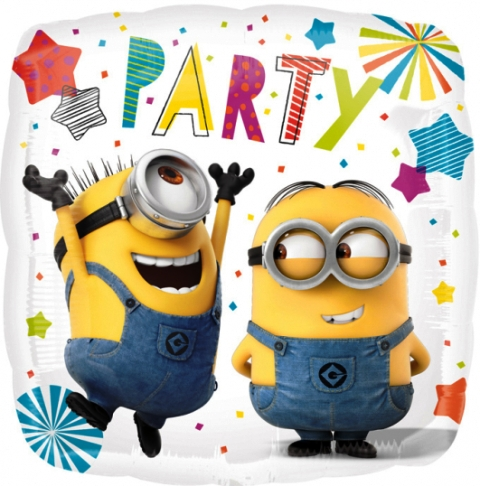

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Unit Testing Phase

Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Unit Testing Phase και περιγράψτε τη λογική βάσει της οποίας στήσατε τα assertions των test σας.

### *Ακολουθεί η τεκμηρίωση και ο σχολιασμός κώδικα της Unit Testing Phase:*

# **Συνοπτικά:**

Στηριζόμενος στο περιεχόμενο των διαλέξεων, δημιούργησα μία κλάση `TestNewsAnalyzer` και έκανα 5 τεστ τα οποία αναλύω στη συνέχεια.

**Εδώ να σημειωθεί ότι σημαντική προϋπόθεση για να τρέξει ομαλά το παραπάνω `code cell` είναι να έχει τρέξει πρώτα ο κώδικας της Refactoring Phase (για αρχικοποίση logger, κ.λπ.).**

Η μόνη διαφορά με τις διαλέξεις είναι ότι είχα ένα πρόβλημα με τις γραμμές:
```python
if __name__ == '__main__':
	sys.exit(unittest.main())
```

Και τις αντικατέστησα με:
```python
if __name__ == '__main__':
	unittest.main(argv=['first-arg-is-ignored'], exit=False)
```
βάσει του άρθρου που διάβασα [εδώ](https://medium.com/@vladbezden/using-python-unittest-in-ipython-or-jupyter-732448724e31).

# **Αναλυτικά:**

* Η `test_Jaccard_Index_Score` ελέγχει ότι όλα τα score από ένα υποσύνολο δεδομένων που φορτώνουμε (γιατί αλλιώς το τεστ παίρνει αιώνες) ανήκει στο σύνολο [0, 1]. Χρησιμοποιήθηκε η `any()` ώστε, αν βρεθεί έστω και μία παράβαση του `0 <= JI Score <= 1` να κάνει fail το τεστ.

* Η `test_illegal_flag_cli` ελέγχει ότι αν το flag του χρήστη είναι illegal, κάνει `raise TypeError`.

* Οι `test_category_has_documents` και `test_term_has_documents` ελέγχουν ότι δεν υπάρχουν κατηγορίες και όροι που δεν αντιστοιχίζονται σε κανένα document.

* Η `test_stem_term_num` ελέγχει ότι πράγματι φορτώθηκαν όλα τα stems.



In [ ]:
print ("Καλή Δουλειά!")